In [1]:
begin
    using Pkg
    PkgList = ["CSV",           #read .csv
                "DataFrames",   #nice framework for tables -- ~ pandas in Python
                "Ipopt",        #solver for optimization problem
                "JuMP",         #framework for optimization problem formulation -- ~ Pyomo in Python
                "Distributions" # for Chi^2
        ]       
    for package in PkgList
        if Base.find_package(package) == nothing
            Pkg.add(package)
        end
    end
    using CSV, DataFrames, Ipopt, JuMP, Distributions, Plots, LaTeXStrings
    include("src/utils.jl")
end

get_iterations (generic function with 1 method)

# Introduction:
*  **Topics covered:** State Estimation, $\chi^2$ test, optimization with JuMP, work with data (DataFrames)
* **Important notice** the results of this computer lab can be used in future HWs

# State Estimation

Example 4.1 from the book *Electric Energy Systems Analysis and Operation, A. Gomez-Exposito, A. Conejo, and C Canizares, CRS Press, 2009*

![](Network.PNG)


## A quick recap 
> 1. One should minimize, keeping in mind the Power Flow Equations between $V, \delta, P, Q$
$$
J(V,  P, Q, Pl, Ql) = \sum_{k \in \texttt{Buses}} w^V_k (V_k - \tilde{V_k})^2  + \sum_{k \in \texttt{Buses}} w^P_k (P_k - \tilde{P_k})^2 + \sum_{k \in \texttt{Buses}} w^Q_k (Q_k - \tilde{Q_k})^2 + \sum_{(k,l) \in \texttt{Lines}} w^{P}_{kl} (Pl_{kl} - \tilde{P_{kl}})^2 + \sum_{(k,l) \in \texttt{Lines}} w^{Ql}_{kl} (Q_{kl} - \tilde{Q_{kl}})^2,
$$
where $w^V, w^{P}, w^{Q}, w^{Pl}, w^{Ql}$ are the standard deviations of the measurements
> 2. To get the most likely state ($V,  P, Q, Pl, Ql$) of the system
> 3. The value of $J(V^*,  P^*, Q^*, Pl^*, Ql^*)$ can be further used to determine if the measurements are bad using $\chi^2$ test

$$
\tilde{V} \sim \mathcal{N}(V, \sigma^2) 
$$
$$
\tilde{V}_k = V + e, ~ V --~ determinitisitc, ~ e ~ \mathcal{N}(0, \sigma^2_k)
$$

$$
X_i \sim\mathcal{N}(0, 1)
$$
$$
\sum_{i=1}^n X^2_i \sim \chi^2(n)
$$

# Problem data

## Branch data

In [2]:
# Reading branch data 
begin
    include("src/readBranch.jl")
    Buses, GL, BL = readBranch("data/Branch.csv")
end


(1:3, [16.896551724137932 -10.000000000000002 -6.89655172413793; -10.000000000000002 14.10958904109589 -4.10958904109589; -6.89655172413793 -4.10958904109589 11.00614076523382], [-47.241379310344826 30.0 17.241379310344826; 30.0 -40.95890410958904 10.95890410958904; 17.241379310344826 10.95890410958904 -28.200283419933868])

In [3]:
BL

3×3 Matrix{Float64}:
 -47.2414   30.0      17.2414
  30.0     -40.9589   10.9589
  17.2414   10.9589  -28.2003

## Measurement data

In [4]:
begin
    Measurements = CSV.read("data/Measurements.csv", DataFrame)
end

,FromBus,ToBus,Type,Value,W
,Int64,Int64,String3,Float64,Float64
1,1,2,P_L,0.888,15.625
2,1,3,P_L,1.173,15.625
3,2,0,P_i,-0.501,10.0
4,1,2,Q_L,0.568,15.625
5,1,3,Q_L,0.663,15.625
6,2,0,Q_i,-0.286,10.0
7,1,0,V_i,1.006,62.5
8,2,0,V_i,0.968,62.5


## Divide data by types

We will to that for further convenience

In [5]:
# Active power flow in lines

PL_M = filter(row -> row."Type" in ["P_L"], Measurements)
#W = 1 / std(measurement)
PL_M = select(PL_M, Not(:Type))
# Active power at buses

Pi_M = filter(row -> row."Type" in ["P_i"], Measurements)
#W = 1 / std(measurement)
Pi_M = select(Pi_M, Not([:Type, :ToBus]))

# Reactive power flow in lines

QL_M = filter(row -> row."Type" in ["Q_L"], Measurements)
#W = 1 / std(measurement)
QL_M = select(QL_M, Not(:Type))

#Reactive power at buses

Qi_M = filter(row -> row."Type" in ["Q_i"], Measurements)
#W = 1 / std(measurement)
Qi_M = select(Qi_M, Not([:Type, :ToBus]))
# Voltage at buses

Vi_M = filter(row -> row."Type" in ["V_i"], Measurements)
#W = 1 / std(measurement)
Vi_M = select(Vi_M, Not([:Type, :ToBus]))

,FromBus,Value,W
,Int64,Float64,Float64
1,1,1.006,62.5
2,2,0.968,62.5


In [6]:
#give it a try


In [7]:
#how can iterate over measured values from this table?
for row in eachrow(Vi_M)
    println(row)
end



DataFrameRow
 Row │ FromBus  Value    W       
     │ Int64    Float64  Float64 
─────┼───────────────────────────
   1 │       1    1.006     62.5
DataFrameRow
 Row │ FromBus  Value    W       
     │ Int64    Float64  Float64 
─────┼───────────────────────────
   2 │       2    0.968     62.5


# State Estimation Procedure
Since the disperancy between data and out model is (in general) represented as follows,
$$
J(x) = \sum_{k=1}^n w_k (h_k(x) - y_k)^2,
$$
we need to specify $h_k$. In our case these are Power Flow Equations

## Power Flow equations
$$
    \begin{aligned}
        P_i &= V_i \sum_{j=1}^n V_j \left( G_{ij} \cos(\theta_{ij}) + B_{ij} \sin(\theta_{ij}) \right) \\
        Q_i &= V_i \sum_{j=1}^n V_j \left( G_{ij} \sin(\theta_{ij}) - B_{ij} \cos(\theta_{ij}) \right)
    \end{aligned}
$$
## Line Flows
$$
    \begin{aligned}
        P_{ij} &= V_i V_j \left( G_{ij} \cos(\theta_{ij}) + B_{ij} \sin(\theta_{ij}) \right) - G_{ij} V^2_i \\
        Q_{ij} &= V_i V_j \left( G_{ij} \sin(\theta_{ij}) - B_{ij} \cos(\theta_{ij}) \right) + (B_{ij} - b_{s,ij}) V^2_i
    \end{aligned}
$$

In [8]:
function StateEstimation(Buses, GL, BL, Vi_M, Pi_M, Qi_M, PL_M, QL_M)
    """This function creates and solves a JuMP model, i.e., performes state estimation for a power system
        Measurements (Vi_M, Pi_M, etc.) must be presented as DataFrame and must containt 
            index columns (1 or 2, depends if it is for line or bus)
            measurements columns: "Value" -- measurements value
                                  "Weight" -- 1/σ of this measurement
            
        Arguments:
            Buses (UnitRange{Int64}): set of indices for buses
            GL    (Matrix{Float64}) : real part of admittance matrix of the grid
            BL    (Matrix{Float64}) : real part of admittance matrix of the grid
            Vi_M  (DataFrame)       : DataFrame that containts measuremets and its inverse stds for Voltage
            Pi_M  (DataFrame)       : DataFrame that containts measuremets and its inverse stds for Active Power
            Qi_M  (DataFrame)       : DataFrame that containts measuremets and its inverse stds for Reactive Power
            PL_M  (DataFrame)       : DataFrame that containts measuremets and its inverse stds for Active Power Line Flow
            QL_M  (DataFrame)       : DataFrame that containts measuremets and its inverse stds for Reactive Power Line Flow
    
        Returns:
            StateEst (JuMP.Model)   : optimized model of state estimation minimization problem
    """
    # Creating JuMP model
    StateEst = Model(Ipopt.Optimizer)
    # Define model variables
   
    
    @variables(StateEst, 
                        begin
                            V[Buses] ≥ 0, (start=1.0)
                            -pi ≤ δ[Buses] ≤ pi, (start=0.0)
                            P[Buses]
                            Q[Buses]
                            PL[Buses, Buses]
                            QL[Buses, Buses]
                        end)
    # Define constraints
    #Active power injections
    @NLconstraint(StateEst, Pinj[i in Buses],
                            P[i] == V[i] * sum(V[j] * (GL[i,j] * cos(δ[i] - δ[j]) + BL[i,j] * sin(δ[i] - δ[j])) for j in Buses) )
    #Reactive power injections
    @NLconstraint(StateEst, Qinj[i in Buses],
                            Q[i] == V[i] * sum(V[j] * (GL[i,j] * sin(δ[i] - δ[j]) - BL[i,j] * cos(δ[i] - δ[j])) for j in Buses) )
    
    # Line flows
    # Active
    @NLconstraint(StateEst, Pline[i in Buses, j in Buses],
                            PL[i, j] == V[i] * V[j] * (GL[i,j] * cos(δ[i] - δ[j]) + BL[i,j] * sin(δ[i] - δ[j])) - GL[i,j] * V[i]^2)
    # Reactive
    @NLconstraint(StateEst, Qline[i in Buses, j in Buses],
                            QL[i, j] == V[i] * V[j] * (GL[i,j] * sin(δ[i] - δ[j]) - BL[i,j] * cos(δ[i] - δ[j])) + BL[i,j] * V[i]^2)
    # Define objective function
    
    @variable(StateEst, J ≥ 0) # objective function
    @NLconstraint(StateEst,
                        J == sum(row["W"] * ( V[row["FromBus"]] - row["Value"])^2 for row in eachrow(Vi_M)) +
                             sum(row["W"] * ( P[row["FromBus"]] - row["Value"])^2 for row in eachrow(Pi_M)) +
                             sum(row["W"] * ( Q[row["FromBus"]] - row["Value"])^2 for row in eachrow(Qi_M)) + 
                             sum(row["W"] * ( PL[row["FromBus"], row["ToBus"]] - row["Value"])^2 for row in eachrow(PL_M)) + 
                             sum(row["W"] * ( QL[row["FromBus"], row["ToBus"]] - row["Value"])^2 for row in eachrow(QL_M))
    )
    # Solve the optimization and keep track of progress
    set_optimizer_attribute(StateEst, "print_level", 7)
    @objective(StateEst, Min, J)
    
    #optimize!(StateEst)
    redirect_to_files(optimize!, [StateEst], "out/out.txt", "out/err.txt")
    return StateEst
end

StateEstimation (generic function with 1 method)

$$
J(V,  P, Q, Pl, Ql) = \sum_{k \in \texttt{Buses}} w^V_k (V_k - \tilde{V_k})^2  + \sum_{k \in \texttt{Buses}} w^P_k (P_k - \tilde{P_k})^2 + \sum_{k \in \texttt{Buses}} w^Q_k (Q_k - \tilde{Q_k})^2 + \sum_{(k,l) \in \texttt{Lines}} w^{P}_{kl} (Pl_{kl} - \tilde{P_{kl}})^2 + \sum_{(k,l) \in \texttt{Lines}} w^{Ql}_{kl} (Q_{kl} - \tilde{Q_{kl}})^2,
$$


In [9]:
# Get the result
res = StateEstimation(Buses, GL, BL, Vi_M, Pi_M, Qi_M, PL_M, QL_M)

A JuMP Model
Minimization problem with:
Variables: 31
Objective function type: VariableRef
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 7 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 3 constraints
Nonlinear: 25 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: J, P, PL, Pinj, Pline, Q, QL, Qinj, Qline, V, δ

In [10]:
parseRes(X) = round.(collect(JuMP.value.(res[Symbol(X)])), digits=3)
parseRes("δ")

3-element Vector{Float64}:
  0.023
  0.001
 -0.025

# Visualising iterations

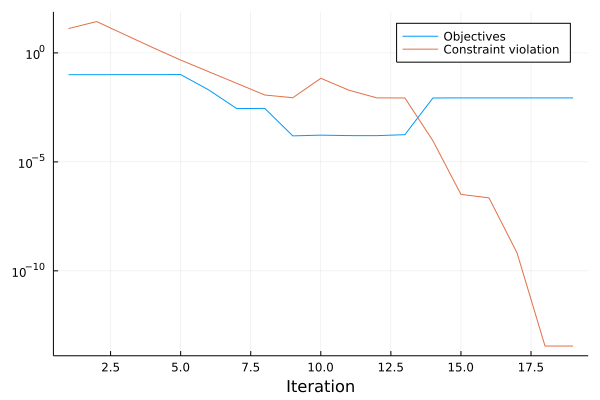

In [11]:

Objectives, _, ContstraintViolations, _, _ = get_iterations("out/out.txt");

plot(Objectives[2:end], label="Objectives")
plot!(ContstraintViolations[2:end], label="Constraint violation")
plot!(xlabel="Iteration")
plot!(yaxis=:log)

# $\chi^2$ test

1. $\alpha$ = 0.01$
2. $
$$

$$

In [12]:
parseRes(X) = round.(collect(JuMP.value.(res[Symbol(X)])), digits=3)

parseRes (generic function with 1 method)

In [13]:
size(Measurements)[1]

8

$$
\mathbb{P} (x \leq X_{value}) = CDF (X_{value})
$$

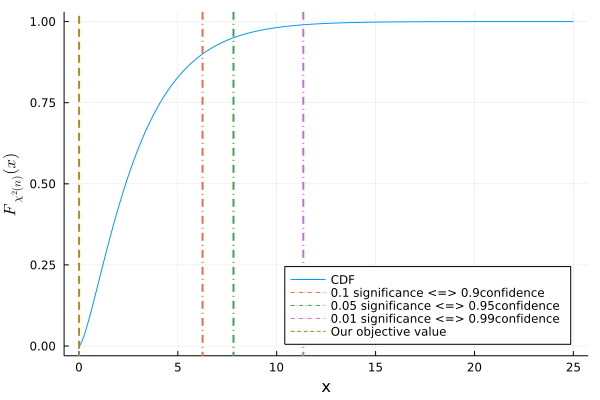

In [14]:
# number of measurement
n = size(Measurements)[1] - (2 * length(Buses) - 1)
# define χ^2
d = Chisq(n)
# define several confidence levels
conf_lvls = [0.1, 0.05, 0.01]
cdf_conf = [quantile(d, 1-cl) for cl in conf_lvls]
#plot cdf
xs = collect(0:0.001:25)
cdfs = [cdf(d, x) for x in xs]
plot(xs, cdfs, label="CDF")
for i in 1:length(cdf_conf)
    vline!([cdf_conf[i]], linewidth=2, linestyle=:dashdot, label=string(conf_lvls[i]) * " significance <=> " * string(1-conf_lvls[i]) * "confidence")
end
vline!([parseRes("J")], linewidth=2, linestyle=:dash, label="Our objective value")
plot!(xlabel="x")
plot!(ylabel=L"F_{\chi^2(n)}(x)")
plot!(legend=:bottomright)

$$
J(x) = \sum_{k=1}^n w_k (h_k(x) - y_k)^2,
$$

$$
\alpha = 0.01
\\
J ~ v.s. ~ quantile_{\chi^2(8)}(1 - \alpha) \\
J ~ > ~ quantile_{\chi^2(8)}(1 - \alpha) -- ~ bad ~data \\
J ~ <= ~ quantile_{\chi^2(8)}(1 - \alpha) -- ~ we ~do ~not ~have ~bad ~data
$$

In [15]:
tst = [1, 2, 3, 4]
tst .^ 2

4-element Vector{Int64}:
  1
  4
  9
 16

# Takeaways
> 1. We know have an example of JuMP usage. **You can use that in the next homework**
> 2. We have a visualisation of optimization process
> 3. We have a visualisation of $\chi^2$ test
> 4. **Open this link and rate this class please!**
https://www.menti.com/poxia4npow